In [1]:
from __future__ import division
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import json
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
import string
import math
from dota_function_definitions import create_dota_dataframe2

96,004 matches (Very High skill, all matchmaking modes) were collected between February 29, 2016 and March 6, 2016. The matches all occurred while the game was on patch 6.86d.

In [2]:
dotaFrame = pd.read_csv('dotaFrame_20160229_to_20160306.csv', sep=',')

In [3]:
with open('heroes.txt', mode='r') as infile:
    reader = csv.reader(infile)
    heroDict = {rows[0]:rows[1] for rows in reader}

In [4]:
len(dotaFrame)

96004

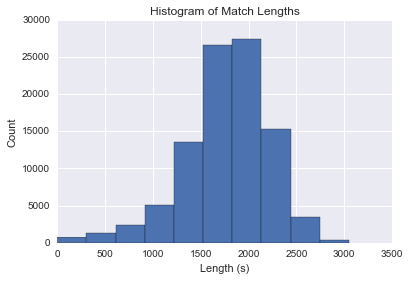

In [5]:
%matplotlib inline
ax = dotaFrame['Match Length (s)'].hist()
ax.set(xlabel='Length (s)', ylabel='Count', title='Histogram of Match Lengths')

We've now imported a fairly large number of matches into a pandas dataframe. The most played game modes are 1 (All Pick) and 22 (Ranked All Pick) which are the only two game modes where all ten players have complete freedom of choice in picking their hero. These two modes embody the chaos that is the 'draft' portion of public matchmaking Dota 2 game, so we will only look at matches for these two game modes in our model. We will also cut out any matches ending before 10 minutes as games that end that early tend to have some skewed factor such as a player abandoning the game early.

In [6]:
dotaFrame = pd.concat([dotaFrame[dotaFrame['Game Mode']==1], dotaFrame[dotaFrame['Game Mode']==22]])
dotaFrame = dotaFrame[dotaFrame['Match Length (s)']>599]

There are 111 heroes currently in the game using hero IDs 1 to 113 (IDs 24 and 108 are unused for reasons unknown). To perform logistic regression, we will use 113 on/off switches for each team indicating whether or not that particular hero is present on the team in a game. Since the current dataframe records the hero for each particular player slot as opposed for just a particular team, we will combine the player slots for each team into a single dataframe cell. From there, we can use the get_dummies() function obtain our 226 switches.

In [7]:
dotaFrame['Radiant']='R'+dotaFrame['Radiant 1'].map(str)+','+'R'+dotaFrame['Radiant 2'].map(str)+','+'R'+dotaFrame['Radiant 3'].map(str)+','+'R'+dotaFrame['Radiant 4'].map(str)+','+'R'+dotaFrame['Radiant 5'].map(str)
dotaFrame['Dire']='D'+dotaFrame['Dire 1'].map(str)+','+'D'+dotaFrame['Dire 2'].map(str)+','+'D'+dotaFrame['Dire 3'].map(str)+','+'D'+dotaFrame['Dire 4'].map(str)+','+'D'+dotaFrame['Dire 5'].map(str)

In [8]:
dotaFrameLogitRadiant = dotaFrame['Radiant'].str.get_dummies(sep=',')
dotaFrameLogitDire = dotaFrame['Dire'].str.get_dummies(sep=',')

In [9]:
dotaFrameLogit = dotaFrameLogitRadiant.join(dotaFrameLogitDire)
dotaFrameLogit['Intercept']=1
dotaFrameLogit['Radiant Win Y/N'] = dotaFrame['Radiant Win Y/N']

We add an intercept term and the winning team information to the resultant dataframe. As seen below, all the data is now represented as 0s and 1s.

In [11]:
dotaFrameLogit.head(10)

,R1,R10,R100,R101,R102,R103,R104,R105,R106,R107,...,D92,D93,D94,D95,D96,D97,D98,D99,Intercept,Radiant Win Y/N
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,True
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
21,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
25,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
35,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,False
37,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,False


We'll split the data into a training set and a testing set. The model will be fit to the training set, and then we will test the model's efficacy on the testing set.

In [12]:
dotaFrameTrain, dotaFrameTest = train_test_split(dotaFrameLogit, test_size=0.2, random_state=0)

In [13]:
len(dotaFrameTrain)

65782

In [14]:
len(dotaFrameTest)

16446

In [15]:
trainColumn = list(dotaFrameLogit.columns.values)[0:-1]

Here, we utilize statsmodels' logistic regression function Logit() to model our data.

In [16]:
model = sm.Logit(dotaFrameTrain['Radiant Win Y/N'], dotaFrameTrain[trainColumn])

In [17]:
result = model.fit(method='bfgs', maxiter=200)

Optimization terminated successfully.
         Current function value: 0.625832
         Iterations: 105
         Function evaluations: 106
         Gradient evaluations: 106


In [18]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        Radiant Win Y/N   No. Observations:                65782
Model:                          Logit   Df Residuals:                    65561
Method:                           MLE   Df Model:                          220
Date:                Sun, 06 Mar 2016   Pseudo R-squ.:                 0.08598
Time:                        18:33:30   Log-Likelihood:                -41168.
converged:                       True   LL-Null:                       -45041.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
R1            -0.6289        nan        nan        nan           nan       nan
R10           -0.2764        nan        nan        nan           nan       nan
R100           0.0227        nan        nan        n

In [19]:
trainingPrediction = result.pred_table()

We can plot the confusion matrix to visualize how well the model does against the training set. Tested against the data used to form the model itself, it predicts ~64.9% of the matches successfully. Interestingly, the model seems to misinterpret Dire Wins as Radiant Wins more often than Radiant Wins as Dire Wins. The model seems to be much better at predicting Radiant wins in general, possibly because upon closer inspection, Radiant wins approximately 56.5% of the time and not a randomized coin flip 50% of the time.

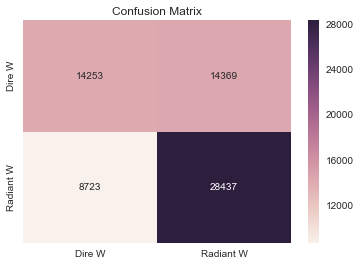

In [20]:
ax = sns.heatmap(trainingPrediction, annot = True, fmt = ".6g", xticklabels = ['Dire W', 'Radiant W'], yticklabels = ['Dire W', 'Radiant W'])
ax.set_title("Confusion Matrix")

In [21]:
dotaFrameTrain['Radiant Win Y/N'].mean()    #percent of matches where Radiant won

0.56489617220516253

We can use the model to predict matches where the Radiant team wins and matches where the Radiant team loses. Luckily, we have that testing dataset available for use! Let's use that below to find ypred, the array of predicted Radiant W/Ls, and compare that to ytest, the array of actual Radiant W/Ls.

In [22]:
ypred = result.predict(dotaFrameTest[trainColumn])

In [23]:
ypred

array([ 0.69164826,  0.80311574,  0.60981552, ...,  0.80621999,
        0.72275008,  0.79649596])

In [24]:
ypred = ypred.round().astype(int)    #convert probabilities to predicted win or loss for Radiant team

In [25]:
ytest = np.ravel(dotaFrameTest['Radiant Win Y/N']).astype(int)  #convert binary dataframe series to int numpy array for comparison

In [26]:
ypred

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
ytest

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(ypred, ytest)

0.64818192873647085

Using this logistic regression model, there is a ~64.8% correct prediction rate on the test set.